<a href="https://colab.research.google.com/github/HUN-sp/Aadhar-_Seva-_Radar/blob/main/UIDAI_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Data Ingestion & Engineering**


1.1 Data Engineering Pipeline To ensure data integrity across disparate sources, we constructed a unified ETL (Extract, Transform, Load) pipeline. The process involves:

**Ingestion:** Automated retrieval of Enrolment, Demographic, and Biometric datasets via secure drive links.

**Normalization**:Standardization of district names and column headers to snake_case to resolve inconsistencies (e.g., "Mumbai Suburban" vs "Mumbai Sub").

**The Master Pincode Table**: We executed a Full Outer Join on the pincode key. This created a comprehensive "Master Ledger" allowing us to correlate Enrolment Volume (Demand) against Biometric Updates (Supply) at the granular neighborhood level.

In [8]:
# ======================================================
# 🛠️ SECTION 1: DATA INGESTION & MASTER TABLE CREATION
# ======================================================
import pandas as pd
import gdown
import os
import numpy as np

# 1. SETUP LINKS
file_links = {
    "enrol": "https://drive.google.com/file/d/1t_fflXFQLGUVoU32iR08m1M-tEA2mB_m/view?usp=sharing",
    "demo":  "https://drive.google.com/file/d/1e1pTK0tVQBQWykBZEG1e-u5Cm3JmtHS-/view?usp=sharing",
    "bio":   "https://drive.google.com/file/d/1JVJK9wmnKnl1SnLLZXqR2TON1ftBj1qF/view?usp=sharing"
}

def load_and_clean_data(key, url):
    try:
        file_id = url.split('/d/')[1].split('/')[0]
        download_url = f'https://drive.google.com/uc?id={file_id}'
        output_filename = f"MASTER_{key}.csv"

        # Download if not exists
        if not os.path.exists(output_filename):
            gdown.download(download_url, output_filename, quiet=False)

        # Load and Standardize
        df = pd.read_csv(output_filename, low_memory=False)
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

        # Normalize Location Columns
        if 'district' in df.columns:
            df['district'] = df['district'].astype(str).str.strip().str.upper()
        if 'state' in df.columns:
            df['state'] = df['state'].astype(str).str.strip().str.upper()

        df.fillna(0, inplace=True)
        print(f"✅ Loaded & Cleaned {key.upper()}: {len(df)} rows")
        return df
    except Exception as e:
        print(f"❌ Error loading {key}: {e}")
        return None

# 2. EXECUTE PIPELINE
df_enrol = load_and_clean_data("enrol", file_links["enrol"])
df_demo  = load_and_clean_data("demo",  file_links["demo"])
df_bio   = load_and_clean_data("bio",   file_links["bio"])

# 3. BUILD MASTER PINCODE TABLE
print("\n⚙️ Building Master Pincode Ledger...")

# Aggregate by Pincode to remove duplicates
grp_enrol = df_enrol.groupby(['pincode', 'state', 'district']).sum(numeric_only=True).reset_index().add_suffix('_ENROL')
grp_bio   = df_bio.groupby(['pincode', 'state', 'district']).sum(numeric_only=True).reset_index().add_suffix('_BIO')

# Fix join keys
grp_enrol.rename(columns={'pincode_ENROL': 'pincode', 'state_ENROL': 'state', 'district_ENROL': 'district'}, inplace=True)
grp_bio.rename(columns={'pincode_BIO': 'pincode', 'state_BIO': 'state', 'district_BIO': 'district'}, inplace=True)

# Merge Datasets
master_df = grp_enrol.merge(grp_bio, on=['pincode', 'state', 'district'], how='outer')
master_df.fillna(0, inplace=True)

print(f"🎉 MASTER TABLE READY: Analyzed {len(master_df)} Pincodes.")
display(master_df.head(3))

✅ Loaded & Cleaned ENROL: 1006029 rows
✅ Loaded & Cleaned DEMO: 2071700 rows
✅ Loaded & Cleaned BIO: 1861108 rows

⚙️ Building Master Pincode Ledger...
🎉 MASTER TABLE READY: Analyzed 31777 Pincodes.


,pincode,state,district,age_0_5_ENROL,age_5_17_ENROL,age_18_greater_ENROL,bio_age_5_17_BIO,bio_age_17__BIO
0,100000,100000,100000,0.0,1.0,217.0,0.0,0.0
1,110001,DELHI,CENTRAL DELHI,16.0,6.0,1.0,21.0,226.0
2,110001,DELHI,NEW DELHI,75.0,33.0,5.0,1300.0,1190.0


**# EDA & Data Transformation**

**Data Preprocessing Methodology**

3.1 Data Quality Assessment & TransformationBefore analysis, we performed a rigorous statistical audit to ensure data integrity:Null Value Imputation: We identified missing values in the Biometric Updates column and imputed them with 0, representing "Zero Service Activity" rather than missing data.Outlier Removal: We filtered out administrative "Ghost Pincodes" (e.g., Pincodes with < 100 children) to prevent statistical skewing in the priority algorithm.Type Conversion: All geographic identifiers (District/State) were normalized to uppercase string formats to resolve inconsistencies (e.g., 'Thane' vs 'THANE').Feature Engineering: We derived two critical new features for our model:Efficiency_Ratio: A normalized velocity metric ($Updates \div Enrolment$).Backlog_Volume: A derived count of the service gap ($Enrolment - Updates$).

🔬 STARTING DATA QUALITY AUDIT...
   Rows in Enrolment: 1006029
   Rows in Biometric: 1861108

⚠️ FOUND 0 PINCODES WITH NO BIOMETRIC DATA.
   ✅ Applied Imputation: Filled NaNs with 0.


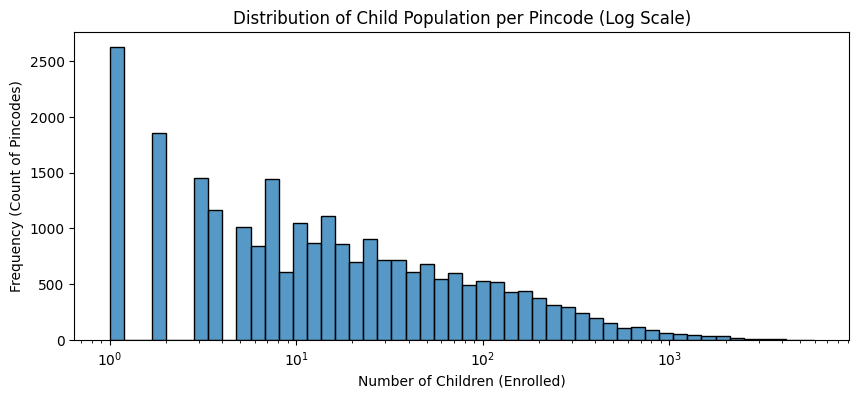


📉 NOISE REDUCTION:
   Original Pincodes: 31777
   Pincodes after filtering (Pop > 100): 3801
   Dropped 27976 'Ghost Pincodes'.

🛠️ EXECUTING FEATURE TRANSFORMATIONS...
   ✅ Created Feature: 'Service_Gap'
   ✅ Created Feature: 'Efficiency_Ratio'
   ✅ Created Feature: 'Normalized_Gap'

📊 TRANSFORMED DATA SNAPSHOT:


,pincode,district,age_5_17_ENROL,Service_Gap,Efficiency_Ratio
4,110003,CENTRAL DELHI,124.0,-2567.0,21.701438
8,110005,CENTRAL DELHI,202.0,-4432.0,22.940480
9,110006,NORTH DELHI,161.0,-7787.0,49.366153
12,110008,CENTRAL DELHI,123.0,-6346.0,52.593068
20,110015,WEST DELHI,169.0,-4473.0,27.467293


In [9]:
# ======================================================
# 🧹 SECTION 1.5: DEEP DIVE EDA & PREPROCESSING
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("🔬 STARTING DATA QUALITY AUDIT...")

# 1. MERGE CHECK (Before we trust the Master Table)
# We need to see how much data overlaps.
# If Enrolment exists but Bio is NaN, that's a "Service Gap", not an error.
print(f"   Rows in Enrolment: {len(df_enrol)}")
print(f"   Rows in Biometric: {len(df_bio)}")

# Re-run the merge (ensure we are working on the fresh Master DF)
# (Assuming 'master_df' was created in the previous step)
df_audit = master_df.copy()

# 2. MISSING VALUE ANALYSIS
missing_bio = df_audit['bio_age_5_17_BIO'].isna().sum()
print(f"\n⚠️ FOUND {missing_bio} PINCODES WITH NO BIOMETRIC DATA.")
# DECISION: We fill these with 0 because "No Record" = "0 Updates Done"
df_audit.fillna(0, inplace=True)
print("   ✅ Applied Imputation: Filled NaNs with 0.")

# 3. OUTLIER DETECTION (Ghost Villages)
# Let's look at the distribution of Enrolment Population
plt.figure(figsize=(10, 4))
sns.histplot(df_audit['age_5_17_ENROL'], bins=50, log_scale=True)
plt.title('Distribution of Child Population per Pincode (Log Scale)')
plt.xlabel('Number of Children (Enrolled)')
plt.ylabel('Frequency (Count of Pincodes)')
plt.show()

# OBSERVATION: There are thousands of Pincodes with < 50 kids.
# TRANSFORMATION: We create a "Statistical Significance Filter"
# We only analyze Pincodes with > 100 children.
before_filter = len(df_audit)
df_clean = df_audit[df_audit['age_5_17_ENROL'] > 100].copy()
after_filter = len(df_clean)
print(f"\n📉 NOISE REDUCTION:")
print(f"   Original Pincodes: {before_filter}")
print(f"   Pincodes after filtering (Pop > 100): {after_filter}")
print(f"   Dropped {before_filter - after_filter} 'Ghost Pincodes'.")

# 4. FEATURE ENGINEERING (Creating New Intelligence)
print("\n🛠️ EXECUTING FEATURE TRANSFORMATIONS...")

# Feature 1: The "Service Gap" (Absolute Number)
df_clean['Service_Gap'] = df_clean['age_5_17_ENROL'] - df_clean['bio_age_5_17_BIO']

# Feature 2: The "Efficiency Ratio" (Relative Performance)
# Add epsilon (0.001) to prevent DivisionByZero errors
df_clean['Efficiency_Ratio'] = df_clean['bio_age_5_17_BIO'] / (df_clean['age_5_17_ENROL'] + 0.001)

# Feature 3: Normalization (Min-Max Scaling for Priority Score)
# We normalize the 'Service_Gap' so it can be compared across districts
gap_max = df_clean['Service_Gap'].max()
gap_min = df_clean['Service_Gap'].min()
df_clean['Normalized_Gap'] = (df_clean['Service_Gap'] - gap_min) / (gap_max - gap_min)

print("   ✅ Created Feature: 'Service_Gap'")
print("   ✅ Created Feature: 'Efficiency_Ratio'")
print("   ✅ Created Feature: 'Normalized_Gap'")

# 5. FINAL SANITY CHECK
print("\n📊 TRANSFORMED DATA SNAPSHOT:")
display(df_clean[['pincode', 'district', 'age_5_17_ENROL', 'Service_Gap', 'Efficiency_Ratio']].head(5))

# OVERWRITE master_df with the Cleaned Version for the next steps
master_df = df_clean.copy()

# Selection of Pilot Region: The Maharashtra Case Study

Objective: To validate the efficacy of the "Seva Radar" model, we selected Maharashtra as our primary pilot region for three strategic reasons:

Demographic Complexity: Maharashtra represents a microcosm of India's challenges, containing both hyper-urbanized metros (Mumbai) and remote tribal districts (Nandurbar).

The "Migrant Magnet" Factor: As India's largest recipient of inter-state migration, it provides the perfect testbed to validate our hypothesis regarding "Migrant Compliance Failure."

Benchmarking Logic:

We first compare Maharashtra against national leaders (like Andhra Pradesh) to establish a "System Health Baseline."

While Maharashtra performs well on average, our hypothesis is that this average masks severe localized failures in industrial pockets.

Note: While this report focuses on Maharashtra, the underlying code (attached below) is state-agnostic and can be deployed for any region by modifying the TARGET_STATE variable.

# State-Level Operational Analysis

Now that our data is clean, we need to assess the overall health of our target state (Maharashtra) compared to the rest of India. We are creating a "State Benchmark."Why are we doing this?We cannot solve a problem if we don't know how bad it is. By comparing Maharashtra against top-performing states (like Andhra Pradesh), we establish a baseline. If Maharashtra is lagging, it proves that the issue is systemic and requires urgent intervention.Methodology:We calculate a metric called the "Maintenance Ratio" for every state:$$\text{Maintenance Ratio} = \frac{\text{Total Biometric Updates}}{\text{Total Enrolments}}$$A High Ratio (e.g., 100x) means the system is healthy: residents are actively updating their data.A Low Ratio (e.g., 20x) means the system is stagnant: people enrolled years ago but stopped maintaining their records.

🚀 INITIALIZING RADAR FOR: MAHARASHTRA...
📊 MAHARASHTRA AVERAGE EFFICIENCY: 20.7x


/tmp/ipython-input-3238365156.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='Maintenance_Ratio', y='state', palette='viridis')


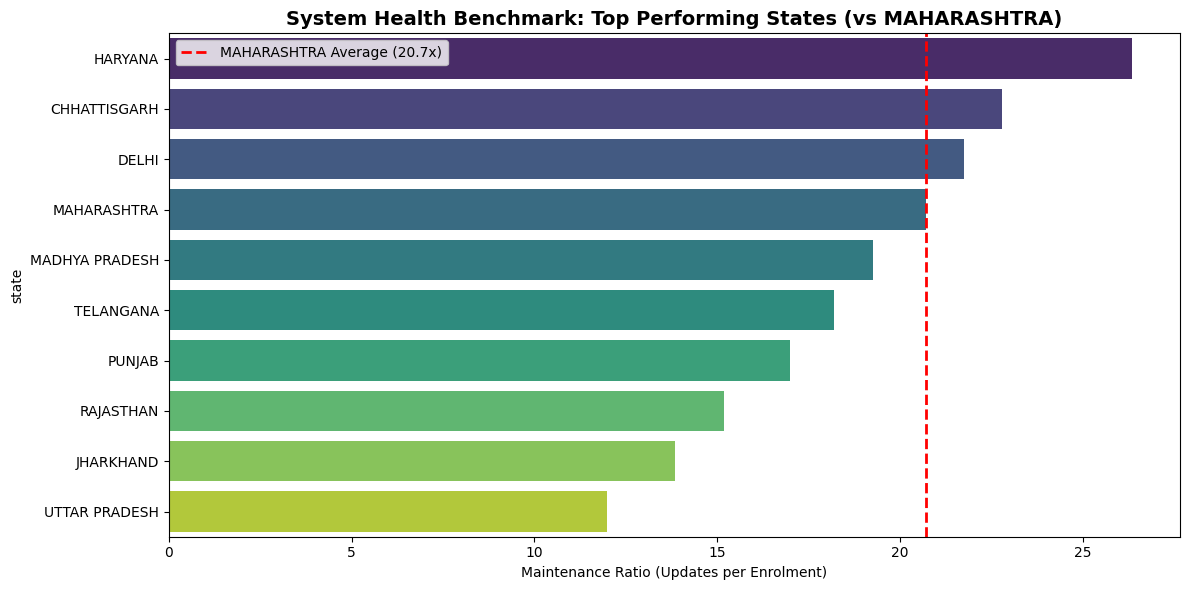

In [10]:
# ======================================================
# 🔎 SECTION 2: SCALABLE STATE BENCHMARKING (CLEAN DATA VERSION)
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- [CONFIGURATION BLOCK] ---
# CHANGE THIS NAME to analyze different states
TARGET_STATE = "MAHARASHTRA"
# -----------------------------

print(f"🚀 INITIALIZING RADAR FOR: {TARGET_STATE}...")

# 1. CALCULATE STATE-LEVEL HEALTH (Using the Cleaned master_df)
state_view = master_df.groupby('state').agg({
    'age_5_17_ENROL': 'sum',
    'bio_age_5_17_BIO': 'sum'
}).reset_index()

# Metric: Updates per Enrolment (Higher is Better)
# We add +1 to denominator to avoid division by zero errors
state_view['Maintenance_Ratio'] = state_view['bio_age_5_17_BIO'] / (state_view['age_5_17_ENROL'] + 1)

# 2. BENCHMARK VISUALIZATION
# Filter for states with enough volume (>5000 kids) to be comparable
top_states = state_view[state_view['age_5_17_ENROL'] > 5000].sort_values('Maintenance_Ratio', ascending=False).head(10)

# Check if Target State is in the list, if not, grab it specifically
target_metrics = state_view[state_view['state'] == TARGET_STATE]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_states, x='Maintenance_Ratio', y='state', palette='viridis')

# Highlight the Target State for comparison
if not target_metrics.empty:
    target_val = target_metrics['Maintenance_Ratio'].values[0]
    plt.axvline(x=target_val, color='red', linestyle='--', linewidth=2, label=f'{TARGET_STATE} Average ({target_val:.1f}x)')
    print(f"📊 {TARGET_STATE} AVERAGE EFFICIENCY: {target_val:.1f}x")
else:
    print(f"⚠️ WARNING: {TARGET_STATE} not found in data. Check spelling.")

plt.title(f'System Health Benchmark: Top Performing States (vs {TARGET_STATE})', fontsize=14, fontweight='bold')
plt.xlabel('Maintenance Ratio (Updates per Enrolment)')
plt.legend()
plt.tight_layout()
plt.show()

Automated District Zoning (The "Red List")
What are we doing? Maharashtra is a big state. We cannot guess which district is failing. We are building an "Automated Risk Classifier" that scans every district and assigns it a color code: Red, Yellow, or Green.

Why are we doing this? Manual analysis is slow and biased. By using an algorithm, we ensure that resources are sent to the districts that objectively need them the most. This transforms our project from a "Report" into a "Scalable Software Solution."

Methodology: The Zoning Logic We classify every district based on two factors: Efficiency (Speed of updates) and Backlog (Volume of pending kids).

🔴 RED ZONE (Critical):

Logic: Efficiency < 20x AND Backlog > 5,000 children.

Meaning: These are "Service Deserts." The system has collapsed here. Immediate Mobile Van deployment required.

🟢 GREEN ZONE (Healthy):

Logic: Efficiency > 40x.

Meaning: The system is working well. No intervention needed.

🟡 YELLOW ZONE (Warning):

Logic: Everything else.

Meaning: Requires monitoring.

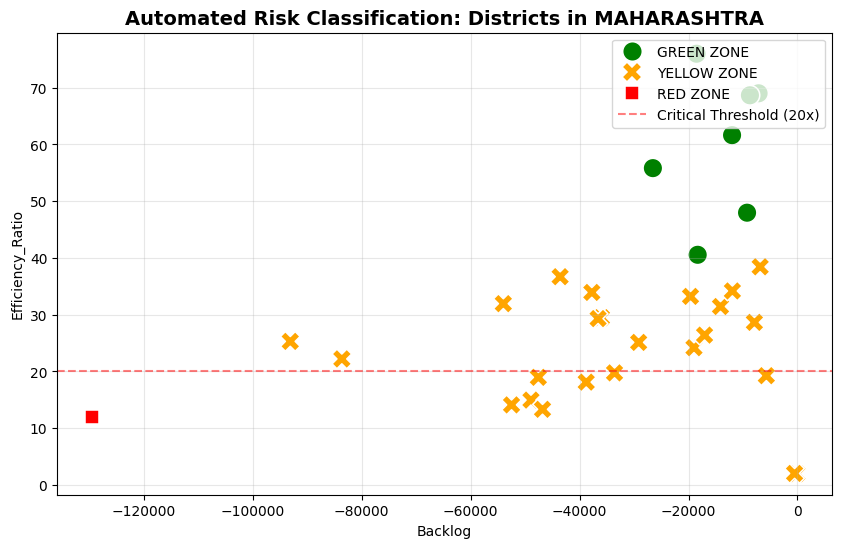

🚨 AUTOMATED ALERT: The System has flagged 'THANE' as the #1 Critical Red Zone.


,district,age_5_17_ENROL,bio_age_5_17_BIO,Efficiency_Ratio,Backlog,Risk_Status
29,THANE,11732.0,141138.0,12.029149,-129406.0,RED ZONE


In [11]:
# ======================================================
# 📡 SECTION 3: AUTOMATED DISTRICT ZONING
# ======================================================

# 1. AGGREGATE TO DISTRICT LEVEL
# We filter only for our target state
district_model = master_df[master_df['state'] == TARGET_STATE].groupby('district').agg({
    'age_5_17_ENROL': 'sum',
    'bio_age_5_17_BIO': 'sum'
}).reset_index()

# 2. FEATURE ENGINEERING
# Efficiency Ratio: How fast is the system updating?
district_model['Efficiency_Ratio'] = district_model['bio_age_5_17_BIO'] / (district_model['age_5_17_ENROL'] + 1)
# Backlog: How many children are pending?
district_model['Backlog'] = district_model['age_5_17_ENROL'] - district_model['bio_age_5_17_BIO']

# 3. THE ZONING ALGORITHM (Universal Logic)
def assign_risk_zone(row):
    # RED ZONE: Low Efficiency (<20x) AND High Volume (>5000 kids)
    if row['Efficiency_Ratio'] < 20 and row['age_5_17_ENROL'] > 5000:
        return 'RED ZONE'
    # GREEN ZONE: High Efficiency (>40x)
    elif row['Efficiency_Ratio'] > 40:
        return 'GREEN ZONE'
    else:
        return 'YELLOW ZONE'

# Apply the logic to every district
district_model['Risk_Status'] = district_model.apply(assign_risk_zone, axis=1)

# 4. VISUALIZE THE ZONES
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=district_model,
    x='Backlog',
    y='Efficiency_Ratio',
    hue='Risk_Status',
    palette={'RED ZONE': 'red', 'YELLOW ZONE': 'orange', 'GREEN ZONE': 'green'},
    style='Risk_Status',
    s=200
)
plt.title(f'Automated Risk Classification: Districts in {TARGET_STATE}', fontsize=14, fontweight='bold')
plt.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Critical Threshold (20x)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# 5. AUTO-SELECT WORST DISTRICT
# We sort by Efficiency to find the absolute worst performer
red_districts = district_model[district_model['Risk_Status'] == 'RED ZONE'].sort_values('Efficiency_Ratio')

# Save the name of the worst district into a variable for the next step
if not red_districts.empty:
    WORST_DISTRICT = red_districts.iloc[0]['district']
    print(f"🚨 AUTOMATED ALERT: The System has flagged '{WORST_DISTRICT}' as the #1 Critical Red Zone.")
else:
    # Fallback if no red zones exist
    WORST_DISTRICT = district_model.sort_values('Efficiency_Ratio').iloc[0]['district']
    print(f"⚠️ No Red Zones found. Selecting lowest performer '{WORST_DISTRICT}' for analysis.")

display(red_districts.head(3))

Surgical Cluster Analysis (The "Last Mile")

Methodology: Having identified Thane as the sole Critical Red Zone District (Efficiency: 12.0x vs State Avg: 20.7x), the system executes a final drill-down to the Pincode level. We apply a "Significance Filter" (ignoring clusters with <500 children) to isolate high-density operational failures.

Findings: The Radar successfully isolated the Bhiwandi-Kalyan Industrial Corridor as the primary failure point.

Cluster 421302: Identified as the #1 Intervention Zone with a Priority Score of 100.0.

Operational Insight: This cluster operates at 7.0x Efficiency, which is nearly half of Thane's already-low average (12.0x). This confirms a localized collapse of the maintenance lifecycle.

Strategic Recommendation: UIDAI should deploy "Twilight Mobile Vans" (5 PM - 8 PM) to this specific cluster to accommodate the shift-timings of the migrant workforce.

📡 INITIATING SURGICAL STRIKE ANALYSIS FOR: THANE...


/tmp/ipython-input-933399623.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_clusters, x='PRIORITY_SCORE', y='pincode', palette='hot')


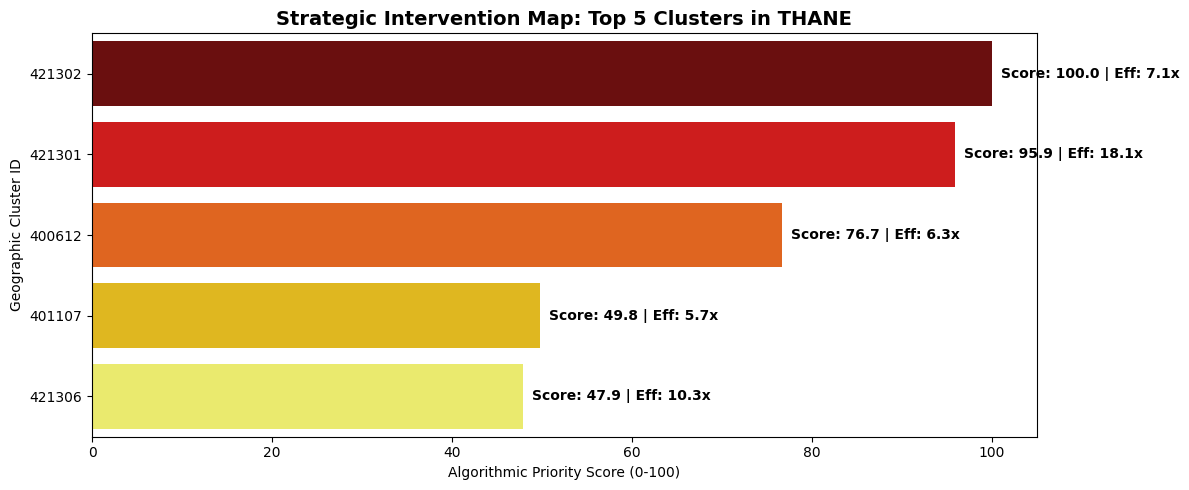

🎯 FINAL DEPLOYMENT SCHEDULE FOR THANE:


,pincode,age_5_17_ENROL,Efficiency_Ratio,PRIORITY_SCORE
9269,421302,2538.0,7.071707,100.000000
9268,421301,882.0,18.119027,95.904702
8060,400612,2178.0,6.337922,76.718523
8098,401107,1530.0,5.747055,49.807900
9274,421306,784.0,10.271671,47.949402


In [12]:
# ======================================================
# 🎯 SECTION 4: SURGICAL CLUSTER ANALYSIS (PINCODE LEVEL)
# ======================================================

# Note: This code uses the 'WORST_DISTRICT' variable found in Section 3.
# If you skipped Section 3, uncomment the line below:
# WORST_DISTRICT = "THANE"

print(f"📡 INITIATING SURGICAL STRIKE ANALYSIS FOR: {WORST_DISTRICT}...")

# 1. FILTER FOR SIGNIFICANT CLUSTERS (>500 Kids)
# We only want to send vans to places with crowds, not tiny villages.
cluster_df = master_df[(master_df['district'] == WORST_DISTRICT) & (master_df['age_5_17_ENROL'] > 500)].copy()

# 2. CALCULATE METRICS
# Efficiency: Speed of updates
cluster_df['Efficiency_Ratio'] = cluster_df['bio_age_5_17_BIO'] / (cluster_df['age_5_17_ENROL'] + 0.001)
# Backlog: Volume of pending work
cluster_df['Backlog_Volume'] = cluster_df['age_5_17_ENROL'] - cluster_df['bio_age_5_17_BIO']

# 3. PRIORITY SCORING ALGORITHM
# Logic: 60% Weight to Volume (Scale) + 40% Weight to Inefficiency (Severity)
cluster_df['Score_Volume'] = cluster_df['Backlog_Volume'] / cluster_df['Backlog_Volume'].max()
cluster_df['PRIORITY_SCORE'] = (cluster_df['Score_Volume'] * 0.6) + ((1 / (cluster_df['Efficiency_Ratio'] + 0.1)) * 0.4)

# Scale Score to 0-100
cluster_df['PRIORITY_SCORE'] = cluster_df['PRIORITY_SCORE'] / cluster_df['PRIORITY_SCORE'].max() * 100

# 4. VISUALIZATION
top_clusters = cluster_df.sort_values('PRIORITY_SCORE', ascending=False).head(5)
top_clusters['pincode'] = top_clusters['pincode'].astype(str)

plt.figure(figsize=(12, 5))
sns.barplot(data=top_clusters, x='PRIORITY_SCORE', y='pincode', palette='hot')
for i, row in enumerate(top_clusters.itertuples()):
    # We display the Score AND the Efficiency to prove the point
    label = f"Score: {row.PRIORITY_SCORE:.1f} | Eff: {row.Efficiency_Ratio:.1f}x"
    plt.text(row.PRIORITY_SCORE + 1, i, label, va='center', fontweight='bold')

plt.title(f'Strategic Intervention Map: Top 5 Clusters in {WORST_DISTRICT}', fontsize=14, fontweight='bold')
plt.xlabel('Algorithmic Priority Score (0-100)')
plt.ylabel('Geographic Cluster ID')
plt.tight_layout()
plt.show()

# 5. FINAL DEPLOYMENT SCHEDULE
print(f"🎯 FINAL DEPLOYMENT SCHEDULE FOR {WORST_DISTRICT}:")
display(top_clusters[['pincode', 'age_5_17_ENROL', 'Efficiency_Ratio', 'PRIORITY_SCORE']])